# Terminator - Revamped

## Load Libs

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
%matplotlib inline

/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Important Functions

In [2]:
def runNameAnalysis(df):
    df['contains_bot'] = df['screen_name'].str.contains('bot',case=False)*1

def calculateRatios(df):
    df['ff_Ratio'] = (df['friends_count']+1)/(df['followers_count']+1)

def assumeVerification(df):
    df.ix[df['verified'].isnull() & df['ff_Ratio']<0.04,'verified'] = 1
    df.ix[df['verified'].isnull() & df['ff_Ratio']>0.04,'verified'] = 0

def isEnglish(df):
    df['english'] = 0
    df.ix[df['lang'].isin(['en','en-gb']),'english'] = 1
    
def assumeExtended(df):
    df.ix[df['has_extended_profile'].isnull() & df['ff_Ratio']<0.02,'has_extended_profile'] = 1
    df.ix[df['has_extended_profile'].isnull() & df['ff_Ratio']>0.02,'has_extended_profile'] = 0

## Training Data

In [3]:
# load data
traindata = pd.read_csv('training_data.csv', sep=",", encoding='latin1')
traindata.fillna('', inplace=True)

# add a column 'svm_guess' with a SVM classification of the description
traindata['svm_guess'] = pd.read_csv('svm_guess.csv', header=None)

runNameAnalysis(traindata)
isEnglish(traindata)

traindata = traindata.drop(['id', 'id_str', 'url', 'default_profile', 'default_profile_image', 'screen_name', 'location',
              'status', 'lang', 'description', 'created_at', 'name'], 1)

calculateRatios(traindata)
assumeVerification(traindata)
assumeExtended(traindata)
# print(np.mean(traindata[traindata['verified']==True]['ff_Ratio']))  #mean = 0.04

for c in traindata.columns:
    if(traindata[c].dtype==object):
        traindata[c] = (traindata[c]).astype(np.float64)

X_train = traindata.drop('bot',1)
y_train = traindata['bot']

## Test Data

In [4]:
testdata = pd.read_csv('test_data_4_students.csv', sep=",", encoding='utf-8')
testdata.fillna('', inplace=True)
testdata = testdata[:575]

# add a svm guess column
testdata['svm_guess'] = pd.read_csv('svm_test_guess.csv', header=None)

testdata['id'] = testdata['id'].astype(np.int64)
testdata = testdata.set_index(['id'])

In [5]:
# add a column 'name_analysis'
runNameAnalysis(testdata)

# do a language analysis thingy
isEnglish(testdata)

In [6]:
testdata = testdata.drop(['id_str', 'url', 'default_profile', 'default_profile_image', 'screen_name', 'location',
              'status', 'description', 'created_at', 'name','bot','lang'], 1)

In [7]:
for c in testdata.columns:
    if(testdata[c].dtype==object):
        testdata[c] = testdata[c].replace(['TRUE','FALSE','None'], [1,0,np.NaN])

for c in testdata.columns:
    if(testdata[c].dtype==object):
        testdata[c] = (testdata[c]).astype(np.float64)

for c in testdata.drop(['verified','has_extended_profile'],1).columns:
    testdata[c] = testdata[c].replace([np.NaN],testdata[c].mean(skipna=True, axis=0))

testdata.columns = ['followers_count', 'friends_count', 'listedcount', 'favourites_count',
       'verified', 'statuses_count','has_extended_profile','svm_guess','contains_bot','english']

In [8]:
testdata.head(5)

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,has_extended_profile,svm_guess,contains_bot,english
id,,,,,,,,,,
2281292622,4466.0,1295.0,111.0,1579.000000,1.0,3036.0,0.0,0,0,1
2344040251,295.0,1016.0,10.0,300.000000,0.0,618.0,0.0,0,0,1
765871267,1001678.0,3017.0,14.0,13040.000000,1.0,3329.0,1.0,0,0,1
4772373433,445.0,487.0,17.0,1112.000000,0.0,46.0,1.0,1,0,0
1324548560,187.0,68.0,13.0,3576.781003,NaN,690359.0,NaN,1,1,0


In [9]:
# CALCULATE RATIOS HERE - AFTER TEST DATA HAS BEEN FIXED
calculateRatios(testdata)
assumeVerification(testdata)
assumeExtended(testdata)

In [10]:
traindata.head(5)

,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,has_extended_profile,bot,svm_guess,contains_bot,english,ff_Ratio
0,1291,0,10,0,True,78554,1.0,1,1,0,0,0.000774
1,1,349,0,38,True,31,1.0,1,1,0,1,175.000000
2,1086,0,14,0,True,713,1.0,1,1,1,1,0.000920
3,33,0,8,0,True,676,1.0,1,0,0,1,0.029412
4,11,745,0,146,True,185,1.0,1,1,0,1,62.166667


## Remove Items

In [12]:
to_drop = ['svm_guess','listedcount','favourites_count']
X_train = X_train.drop(to_drop,1)
# testdata = testdata.drop(to_drop,1)
X_train.head(5)

,followers_count,friends_count,verified,statuses_count,has_extended_profile,contains_bot,english,ff_Ratio
0,1291,0,True,78554,1.0,0,0,0.000774
1,1,349,True,31,1.0,0,1,175.000000
2,1086,0,True,713,1.0,1,1,0.000920
3,33,0,True,676,1.0,0,1,0.029412
4,11,745,True,185,1.0,0,1,62.166667


## Model(s) - Weapon(s)

In [13]:
rfc = RandomForestClassifier()
param_grid = {'n_estimators': np.arange(10, 100, 10),
              'max_features': ['sqrt', 'log2', None],
              'criterion': ['gini', 'entropy'],
              }

'''
All Parameters in a RFC
            'max_depth':[None],
            'min_samples_split':[2],
            'min_samples_leaf':[1],
            'min_weight_fraction_leaf':[0.0],
            'max_leaf_nodes':[None],
            'min_impurity_split':[1e-07],
            'bootstrap':[True],
            'oob_score':[False],
            'n_jobs':[1],
            'random_state':[None],
            'verbose':[0],
            'warm_start':[False],
            'class_weight':[None]
'''
# # Performing a Grid Search to find best RFC
regular_RFC = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10)
regular_RFC.fit(X_train, y_train)
print('Grid Searched RF')
print(regular_RFC.best_params_)

print("RF: score of the best estimator over the leftout set:",regular_RFC.best_score_)
print("RF: score of the best estimator over the complete set:",regular_RFC.best_estimator_.score(X_train,y_train))
print()

Grid Searched RF
{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 40}
RF: score of the best estimator over the leftout set: 0.888809438684
RF: score of the best estimator over the complete set: 0.998569896317



RSXG: score of the best estimator over the leftout set: 0.890239542367
RSXG: score of the best estimator over the complete set: 0.908115838398



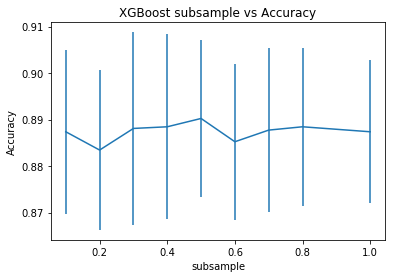

In [14]:
# XGBOOST
##############
# ROW SAMPLING
model = XGBClassifier()

subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
row_XG = grid_search.fit(X_train, y_train)

print("RSXG: score of the best estimator over the leftout set:",row_XG.best_score_)
print("RSXG: score of the best estimator over the complete set:",row_XG.best_estimator_.score(X_train,y_train))
print()

means_rs = row_XG.cv_results_['mean_test_score']
stds_rs = row_XG.cv_results_['std_test_score']

# plot
pyplot.figure()
pyplot.errorbar(subsample, means_rs, yerr=stds_rs)
pyplot.title("XGBoost subsample vs Accuracy")
pyplot.xlabel('subsample')
pyplot.ylabel('Accuracy')
pyplot.savefig('subsample.png')

CSXG: score of the best estimator over the leftout set: 0.891312120129
CSXG: score of the best estimator over the complete set: 0.907758312478



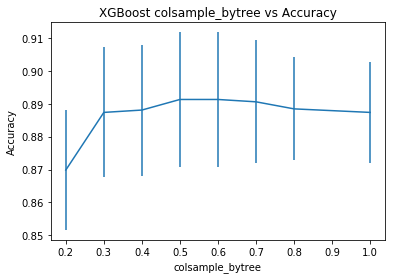

In [15]:
# COLUMN SAMPLING
colsample_bytree = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bytree=colsample_bytree)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
col_XG = grid_search.fit(X_train, y_train)

print("CSXG: score of the best estimator over the leftout set:",col_XG.best_score_)
print("CSXG: score of the best estimator over the complete set:",col_XG.best_estimator_.score(X_train,y_train))
print()

means_cs = col_XG.cv_results_['mean_test_score']
stds_cs = col_XG.cv_results_['std_test_score']

# plot
pyplot.figure()
pyplot.errorbar(colsample_bytree, means_cs, yerr=stds_cs)
pyplot.title("XGBoost colsample_bytree vs Accuracy")
pyplot.xlabel('colsample_bytree')
pyplot.ylabel('Accuracy')
pyplot.savefig('colsample_bytree.png')

SSXG: score of the best estimator over the leftout set: 0.890239542367
SSXG: score of the best estimator over the complete set: 0.908115838398



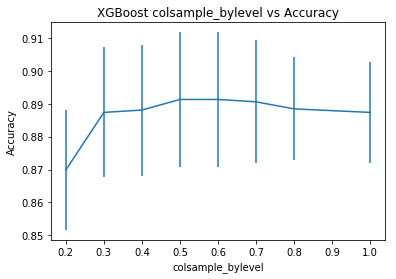

In [16]:
# SPLIT SAMPLE
colsample_bylevel = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bylevel=colsample_bylevel)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
split_XG = grid_search.fit(X_train, y_train)

print("SSXG: score of the best estimator over the leftout set:",split_XG.best_score_)
print("SSXG: score of the best estimator over the complete set:",split_XG.best_estimator_.score(X_train,y_train))
print()

means_ss = col_XG.cv_results_['mean_test_score']
stds_ss = col_XG.cv_results_['std_test_score']

# plot
pyplot.figure()
pyplot.errorbar(colsample_bylevel, means_ss, yerr=stds_ss)
pyplot.title("XGBoost colsample_bylevel vs Accuracy")
pyplot.xlabel('colsample_bylevel')
pyplot.ylabel('Accuracy')
pyplot.savefig('colsample_bylevel.png')

### Nuke

In [ ]:
# need a better model? 

In [ ]:
np.max(testdata)

## Create Predictions File

In [ ]:
# #select model from above
# preds_for = split_XG

# testdata['y_pred'] = preds_for.predict(testdata)
# answer = pd.DataFrame(testdata['y_pred'])
# answer.to_csv('results_file_new.csv',index=True,index_label='Id',header=['Bot'])
# testdata = testdata.drop('y_pred',1)

### Curves

In [17]:
def reportCard(y_true, y_pred, y_proba,name):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    %matplotlib inline
    print('\nReport for:',name)
    target_names = ['bot', 'not-bot']
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    print("Confusion Matrix\n",metrics.confusion_matrix(y_true,y_pred))
    print("F1 Score:",metrics.f1_score(y_true,y_pred))
    print("Accuracy:",metrics.accuracy_score(y_true,y_pred))
    print("Log Loss:",metrics.log_loss(y_true,y_pred))
    print("AUC Score:",metrics.roc_auc_score(y_true,y_proba[:,1]))
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_proba[:,1])
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for {}'.format(name))
    plt.legend(loc='best')
    plt.show()

    print()


In [18]:
def adaboostedRFC(best_rfc,X,Y):
    from sklearn.ensemble import AdaBoostClassifier

    brfc = AdaBoostClassifier(best_rfc,
                          algorithm="SAMME.R",
                          n_estimators=10)
    bScores = cross_val_score(brfc, X, Y, cv=10)
    print('mean crossvalidated accuracy for training set after Adaboost: {}'.format(np.mean(bScores)))
    return brfc.fit(X,Y)

In [19]:
import random
random.seed = 0

split = np.random.rand(len(X_train)) < 0.8
X_tr = X_train[split]
X_te = X_train[~split]
Y_tr = y_train[split]
Y_te = y_train[~split]

In [22]:
# X_tr = X_train.iloc[:int(len(X_train)*0.8)]
# Y_tr = y_train.iloc[:int(len(y_train)*0.8)]
    
# X_te = X_train.iloc[int(len(X_train)*0.8)+1:]
# Y_te = y_train.iloc[int(len(y_train)*0.8)+1:]      
xgBoosted = {}
print("\nXG Boosted")
xgBoosted['rs'] = row_XG.best_estimator_.fit(X_tr, Y_tr)
xg_pred_rs = xgBoosted['rs'].predict(X_te)
xg_pred_prob_rs = xgBoosted['rs'].predict_proba(X_te)
print("row done")   
xgBoosted['cs'] = col_XG.best_estimator_.fit(X_tr, Y_tr)
xg_pred_cs = xgBoosted['cs'].predict(X_te)
xg_pred_prob_cs = xgBoosted['cs'].predict_proba(X_te)
print("col done")   
xgBoosted['ss'] = split_XG.best_estimator_.fit(X_tr, Y_tr)
xg_pred_ss = xgBoosted['ss'].predict(X_te)
xg_pred_prob_ss = xgBoosted['ss'].predict_proba(X_te)
print("all done")   


XG Boosted
row done
col done
all done


In [24]:
print("\nRandom Forest")
best_rfc =  regular_RFC.fit(X_tr, Y_tr)
grid_rfc_pred = best_rfc.predict(X_te)
grid_rfc_pred_prob = best_rfc.predict_proba(X_te)

print("\nAdaboosted")
adaboosted = adaboostedRFC(best_rfc.best_estimator_,X_tr,Y_tr)
ada_pred = adaboosted.predict(X_te)
ada_pred_prob = adaboosted.predict_proba(X_te)


Random Forest

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.884634322856428


*****BOF*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        bot       0.83      0.93      0.88       293
    not-bot       0.92      0.81      0.86       285

avg / total       0.87      0.87      0.87       578

Confusion Matrix
 [[272  21]
 [ 55 230]]
F1 Score: 0.858208955224
Accuracy: 0.868512110727
Log Loss: 4.54145985737
AUC Score: 0.937512723789


/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


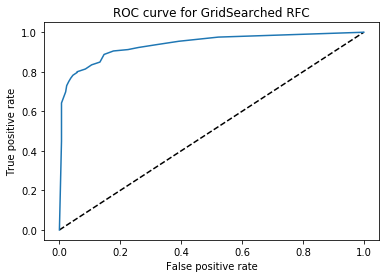



Report for: Adaboosted
             precision    recall  f1-score   support

        bot       0.82      0.92      0.87       293
    not-bot       0.90      0.80      0.85       285

avg / total       0.86      0.86      0.86       578

Confusion Matrix
 [[269  24]
 [ 58 227]]
F1 Score: 0.847014925373
Accuracy: 0.858131487889
Log Loss: 4.89999801855
AUC Score: 0.938734207532


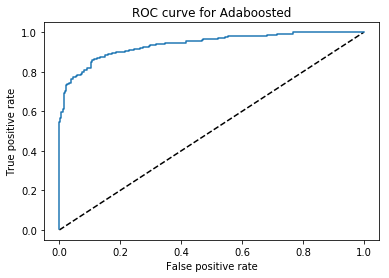



Report for: XG RS
             precision    recall  f1-score   support

        bot       0.84      0.92      0.88       293
    not-bot       0.91      0.81      0.86       285

avg / total       0.87      0.87      0.87       578

Confusion Matrix
 [[270  23]
 [ 53 232]]
F1 Score: 0.859259259259
Accuracy: 0.868512110727
Log Loss: 4.54146262414
AUC Score: 0.950152685468


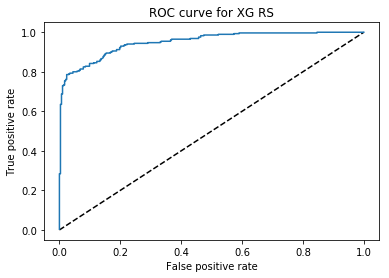



Report for: XG CS
             precision    recall  f1-score   support

        bot       0.84      0.93      0.88       293
    not-bot       0.92      0.81      0.86       285

avg / total       0.88      0.87      0.87       578

Confusion Matrix
 [[272  21]
 [ 53 232]]
F1 Score: 0.862453531599
Accuracy: 0.871972318339
Log Loss: 4.42194852036
AUC Score: 0.952859110233


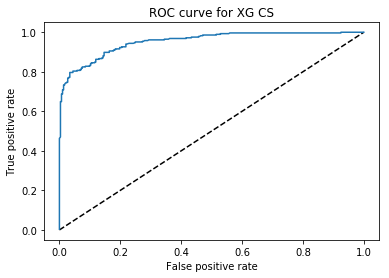



Report for: XG SS
             precision    recall  f1-score   support

        bot       0.83      0.93      0.88       293
    not-bot       0.92      0.81      0.86       285

avg / total       0.88      0.87      0.87       578

Confusion Matrix
 [[273  20]
 [ 55 230]]
F1 Score: 0.859813084112
Accuracy: 0.870242214533
Log Loss: 4.48170280548
AUC Score: 0.951919046764


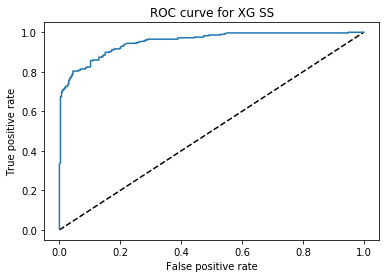


*****EOF*****


In [25]:
print("*****BOF*****")
reportCard(Y_te, grid_rfc_pred, grid_rfc_pred_prob,'GridSearched RFC')
reportCard(Y_te, ada_pred, ada_pred_prob,'Adaboosted')
reportCard(Y_te, xg_pred_rs, xg_pred_prob_rs,'XG RS')
reportCard(Y_te, xg_pred_cs, xg_pred_prob_cs,'XG CS')
reportCard(Y_te, xg_pred_ss, xg_pred_prob_ss,'XG SS')
print("*****EOF*****")

In [26]:
def SingleROC(y_true, predictions,names):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    
    for y_proba, name in zip(predictions,names):
        curr_auc = metrics.roc_auc_score(y_true,y_proba[:,1])
    
        fpr,tpr,thresholds = metrics.roc_curve(y_true,y_proba[:,1])
        plt.plot(fpr, tpr, label = '{} - AUC: {}'.format(name,curr_auc))
        
    plt.title('ROC curves')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='best')
    plt.show()
    print()


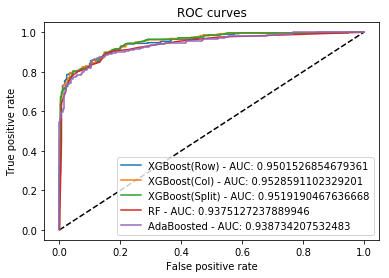

In [31]:
y_true = Y_te
predictions = [xg_pred_prob_rs, xg_pred_prob_cs, xg_pred_prob_ss, grid_rfc_pred_prob, ada_pred_prob]
names = ['XGBoost(Row)','XGBoost(Col)','XGBoost(Split)','RF','AdaBoosted']
SingleROC(y_true,predictions,names)